## Analysis of the workflow lifetime and their distribution in each status
This notebook is used to parse workflows from ReqMgr2 and properly understand their lifetime and time distribution according to their statuses.

In [71]:
import os
import sys
import requests
import json
import statistics
from pprint import pprint
from tabulate import tabulate

myCert = "/Users/amaltar2/Devel/DockerWMCore/certs/servicecert.pem"
myKey = "/Users/amaltar2/Devel/DockerWMCore/certs/servicekey.pem"

### Fetch workflows from ReqMgr2

In [25]:
headers = {"Content-type": "application/json", "Accept": "application/json"}
reqmgrUrl = "https://cmsweb.cern.ch/reqmgr2/data/request"
params = {"name": "cmsunified_task_PPD-Run3Winter23Digi-00030__v1_T_230609_094934_6689"}
data = requests.get(reqmgrUrl, params=params, headers=headers, cert=(myCert, myKey), verify=False)
if data.ok is True:
    data = data.json()['result']

[{'cmsunified_task_PPD-Run3Winter23Digi-00030__v1_T_230609_094934_6689': {'_id': 'cmsunified_task_PPD-Run3Winter23Digi-00030__v1_T_230609_094934_6689', 'Group': 'DATAOPS', 'Requestor': 'cmsunified', 'ProcessingString': {'PPD-Run3Winter23Digi-00030_0': 'FlatPU0to80GTv4BTag_126X_mcRun3_2023_forPU65_forBTag_v1', 'PPD-Run3Winter23Reco-00030_0': 'FlatPU0to80GTv4BTag_GTv4BTag_126X_mcRun3_2023_forPU65_forBTag_v1', 'PPD-Run3Winter23MiniAOD-00026_0': 'FlatPU0to80GTv4BTag_GTv4BTag_MiniGTv4BTag_126X_mcRun3_2023_forPU65_forBTag_v1', 'PPD-Run3Winter23NanoAOD-00026_0': 'FlatPU0to80GTv4BTag_GTv4BTag_MiniGTv4BTag_NanoGTv4BTag_126X_mcRun3_2023_forPU65_forBTag_v1'}, 'ScramArch': ['el8_amd64_gcc10'], 'SizePerEvent': 1930.782, 'Memory': 7900, 'PrepID': 'task_PPD-Run3Winter23Digi-00030', 'RequestType': 'StepChain', 'TimePerEvent': 37.3402, 'AcquisitionEra': {'PPD-Run3Winter23Digi-00030_0': 'Run3Winter23Digi', 'PPD-Run3Winter23Reco-00030_0': 'Run3Winter23Reco', 'PPD-Run3Winter23MiniAOD-00026_0': 'Run3Winter

/Users/amaltar2/.virtualenvs/py3.10/lib/python3.10/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


### OR, fetch workflows directly from CouchDB - including archived workflows

In [47]:
%%time
couchUrl = "https://cmsweb.cern.ch/couchdb/reqmgr_workload_cache/_design/ReqMgr/_view/bydate"
queryParams = {"startkey": "[2022,4,1]", "endkey": "[2023,4,1]", "include_docs": True}
data = requests.get(couchUrl, params=queryParams, headers=headers, cert=(myCert, myKey), verify=False)
print(data)
if data.ok is True:
    data = data.json()['rows']
print(f"Total number of workflows: {len(data)}")

/Users/amaltar2/.virtualenvs/py3.10/lib/python3.10/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


<Response [200]>
Total number of workflows: 236810


### save this workflow data in a json to avoid this heavy query against CouchDB

In [48]:
with open("workflow_dump.json", "w") as fo:
    json.dump(data, fo, indent=2)

## parse each document creating a timeline per campaign

In [100]:
%%time
results = []
for wflow in data:
    summary = {}
    summary["RequestName"] = wflow["doc"]["RequestName"]
    summary["RequestType"] = wflow["doc"]["RequestType"]
    summary["RequestStatus"] = wflow["doc"]["RequestStatus"]
    summary["Campaign"] = wflow["doc"]["Campaign"]
    summary["StatusDuration"] = []
    ## then parse status transition
    totalTransitions = len(wflow["doc"]["RequestTransition"])
    for idx, item in enumerate(wflow["doc"]["RequestTransition"]):
        thisTransition = {}
        if idx + 1 == totalTransitions:
            # then we are in the last transition, grab the total workflow wallclocktime
            thisTransition["Status"] = "total"
            thisTransition["DurationSecs"] = item["UpdateTime"] - wflow["doc"]["RequestTransition"][0]["UpdateTime"]
        else:
            # intermediate transitions, use the next step to calculate time duration
            thisTransition["Status"] = item["Status"]
            thisTransition["DurationSecs"] = wflow["doc"]["RequestTransition"][idx + 1]["UpdateTime"] - item["UpdateTime"]
        summary["StatusDuration"].append(thisTransition)
    results.append(summary)

### And dump this summary in a file as well
with open("wflow_summary.json", "w") as fo:
    json.dump(data, fo, indent=2)

CPU times: user 1min 2s, sys: 16.1 s, total: 1min 18s
Wall time: 1min 45s


In [101]:
# this is equivalent to the total number of workflows retrieved from CouchDB
print(f"Have a total of {len(results)} for the range of 1/April/2022 - 1/April/2023")

# now filter out workflows that ended up in rejected-archived and aborted-archived,
# assuming that they are not relevant for this analysis (even though, depending on the
# case, they might have ran to completion before being aborted!!!)
normalResults = []
rejectedResults = []
for wflow in results:
    if wflow["RequestStatus"] in ("rejected-archived", "aborted-archived"):
        rejectedResults.append(wflow)
    else:
        normalResults.append(wflow)
print(f"  where (rejected/aborted)-archived workflows account to: {len(rejectedResults)}")    
print(f"  and {len(normalResults)} are active and/or normal-archived")    

Have a total of 236810 for the range of 1/April/2022 - 1/April/2023
  where (rejected/aborted)-archived workflows account to: 82051
  and 154759 are active and/or normal-archived


## grab some statistics for these workflows

In [102]:
ACTIVE_STATUS = ["new",
                 "assignment-approved",
                 "assigned",
                 "staging",
                 "staged",
                 "acquired",
                 "running-open",
                 "running-closed",
                 "force-complete",
                 "completed",
                 "closed-out",
                 "announced",
                 "rejected",
                 "total"]  # this one is not a real status

# this object will contain all the absolute values for each workflow in each state
wflowValues = {}
for status in ACTIVE_STATUS:
    wflowValues[status] = []
for wflow in normalResults:
    for statusDict in wflow["StatusDuration"]:
        if statusDict["Status"] == "normal-archived":
            # FIXME some bug. I guess one request had this status update twice(?)
            continue
        wflowValues[statusDict["Status"]].append(statusDict["DurationSecs"])

In [104]:
# while this object will contain final stats for workflows in a given status
columnNames = ["status", "mean (days)", "median (days)", "stdev (days)"]
wflowStats = []
daySecs = 24 * 3600
for status in wflowValues:
    thisStats = []
    thisStats.append(status)
    thisStats.append(round(statistics.mean(wflowValues[status]) / daySecs, 2))
    thisStats.append(round(statistics.median(wflowValues[status]) / daySecs, 2))
    thisStats.append(round(statistics.stdev(wflowValues[status]) / daySecs, 2))
    wflowStats.append(thisStats)

#pprint(wflowStats)
print(tabulate(wflowStats, headers=columnNames, tablefmt="fancy_grid"))

╒═════════════════════╤═══════════════╤═════════════════╤════════════════╕
│ status              │   mean (days) │   median (days) │   stdev (days) │
╞═════════════════════╪═══════════════╪═════════════════╪════════════════╡
│ new                 │          0.74 │            0    │           1.74 │
├─────────────────────┼───────────────┼─────────────────┼────────────────┤
│ assignment-approved │         10.15 │            0.05 │          24.33 │
├─────────────────────┼───────────────┼─────────────────┼────────────────┤
│ assigned            │          0.01 │            0    │           0.17 │
├─────────────────────┼───────────────┼─────────────────┼────────────────┤
│ staging             │          0.84 │            0.03 │           3.38 │
├─────────────────────┼───────────────┼─────────────────┼────────────────┤
│ staged              │          0.02 │            0.01 │           0.1  │
├─────────────────────┼───────────────┼─────────────────┼────────────────┤
│ acquired            │  

## now make a normal distribution



In [107]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

Total values: 154759, mean (secs): 3176239.13, stddev (secs): 3751940.94
Few seconds samples: [552052, 552076, 552435, 552198, 552081, 359565, 359387, 359637, 359412, 328850]
Total values: 154759, mean (days): 36.76, stddev (days): 43.43
Few days samples: [6.39, 6.39, 6.39, 6.39, 6.39, 4.16, 4.16, 4.16, 4.16, 3.81]


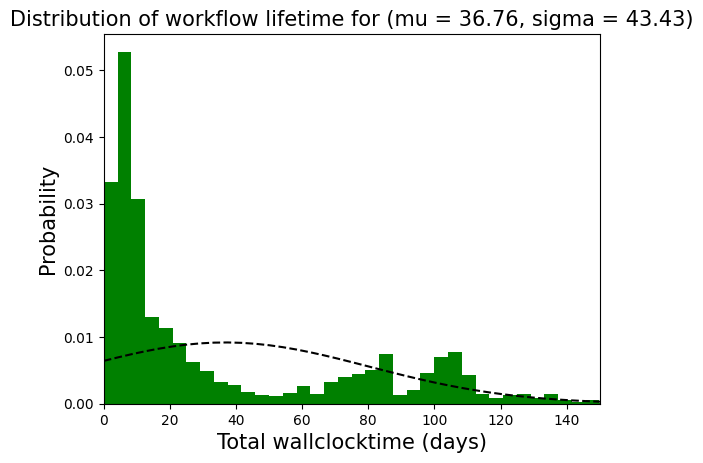

In [135]:
# calculate mean and std dev for the total wallclocktime - in days
#totalMean = round(statistics.mean(wflowValues["total"]) / daySecs, 2))
#totalStdDev = round(statistics.stdev(wflowValues["total"]) / daySecs, 2))
totalMean = round(statistics.mean(wflowValues["total"]), 2)
totalStdDev = round(statistics.stdev(wflowValues["total"]), 2)
print(f"Total values: {len(wflowValues['total'])}, mean (secs): {totalMean}, stddev (secs): {totalStdDev}")
print(f"Few seconds samples: {wflowValues['total'][:10]}")

totalDays = [round(totalSecs / daySecs, 2) for totalSecs in wflowValues["total"]]
meanDays = round(totalMean / daySecs, 2)
stdDevDays = round(totalStdDev / daySecs, 2)
print(f"Total values: {len(totalDays)}, mean (days): {meanDays}, stddev (days): {stdDevDays}")
print(f"Few days samples: {totalDays[:10]}")

n, bins, patches = plt.hist(totalDays, bins=100, density = 1, color ='green')
y = ((1 / (np.sqrt(2 * np.pi) * stdDevDays)) *
     np.exp(-0.5 * (1 / stdDevDays * (bins - meanDays))**2))
 
plt.plot(bins, y, '--', color ='black')
plt.xlim(0, 150) 
plt.title(f'Distribution of workflow lifetime for (mu = {meanDays}, sigma = {stdDevDays})', fontsize='15')
plt.xlabel('Total wallclocktime (days)', fontsize='15')
plt.ylabel('Probability', fontsize='15')
 
plt.show()
